<a href="https://colab.research.google.com/github/cherrypicker1122/FraudDetectionPractice/blob/main/practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import math
import os.path as path
import shutil

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from keras import optimizers, metrics, callbacks
from tensorflow import keras


# 랜덤 시드 고정
np.random.seed(22)

## 데이터 특성


creditcard.csv 데이터 특성
1. 30개 컬럼으로 구성
2. 입력 인자간 연관성 없음
3. 데이터 null 없음


## 데이터 로드
내용 이해하는데 그렇게 까지 중요하지 않은 공통 작업은 Preprocessing 클래스에서 작업


In [ ]:
import sys

class Preprocessing:

    def load_data(self):
        #file path csv 읽어서 output 데이터 , input 데이터 나눠서 리턴

        # colab 에서 실행중이면 google drive mount 하기
        if 'google.colab' in sys.modules :
            from google.colab import drive # colab에서 실행중이면 google.colab이 sys.modules에 있다고 한다
            drive.mount('/content/drive')
            data = pd.read_csv(self.get_root_path()+"creditcard.csv", delimiter=',', dtype=np.float32)
        else :
            # colab아닌 환경이라면 그냥 읽어오기
            data = pd.read_csv("dataset/creditcard.csv", delimiter=',', dtype=np.float32)

        # 분석과 관련이 없는 Time 컬럼 삭제
        data.drop(columns="Time", inplace=True)
        data.head()

        x_data = np.array(data.iloc[:,0:-1].values, dtype=np.float32) # input 컬럼들 추출
        y_data = np.array(data.iloc[:,[-1]].values, dtype=np.float32) # output(class) 컬럼 추출

        return x_data, y_data

    def get_root_path(self):
      # 모델 & 중간 저장용 경로 리턴
      if 'google.colab' in sys.modules : return '/content/drive/MyDrive/'
      else : return ''


## 기본
Normalization + Batch Normalization + Dropout 만 추가하여 테스트

In [ ]:
pr = Preprocessing()
x_data, y_data = pr.load_data()

# Normalization
scaler = MinMaxScaler()
x_data = scaler.fit_transform(x_data)

# Dataset Split
# 20231024 전체 데이터를 넣어서 normalize 시킨 후에 분리해야 함.
# 분리후 x_train따로 x_test 따로 scaler 적용하면 기준 min max값이 달라져서 test set 에서
# f1 score가 낮게 나오는 문제가 있었음
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1,  random_state=22, stratify=y_data)


# Model Build
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu'),        # 입력층
    tf.keras.layers.BatchNormalization(synchronized=True),  # 각 배치마다 normalization 수행
    tf.keras.layers.Dropout(0.2),                           # dropout 으로 랜덤으로 신경망 끄기
    tf.keras.layers.Dense(64, activation = 'relu'),         # 은닉층
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation = 'relu'),
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')          # 출력층
])


# Hyper-parameter tunning (optmizer, cost function)
learning_rate = 0.005
batch_size = 8192
epoch= 3000


# ndarray -> dataset 변환 후 batch size세팅
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.batch(batch_size)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss = 'binary_crossentropy',
              metrics=[ tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])


callback = [callbacks.ModelCheckpoint(pr.get_root_path()+'basic.keras')]

# Training
history = model.fit(dataset, epochs=epoch, callbacks=[callback])

model.save(pr.get_root_path()+'fraud.basic')

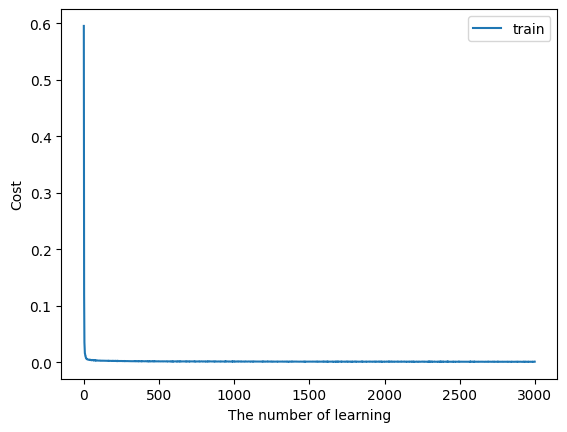

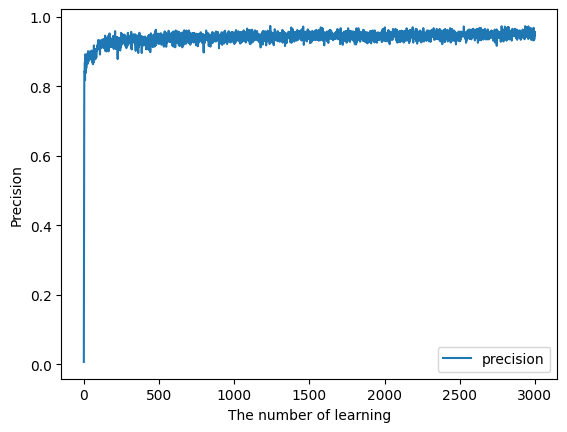

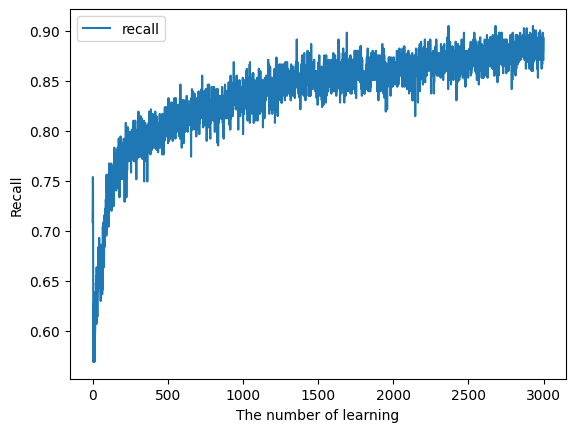

891/891 - 1s - loss: 0.0059 - precision: 0.9706 - recall: 0.6735 - 1s/epoch - 2ms/step
precision: 0.970588207244873, recall: 0.6734693646430969


In [ ]:
# Visualization

plt.plot(history.history['loss'], label='train')
plt.xlabel("The number of learning")
plt.ylabel("Cost")
plt.legend()
plt.show()

plt.plot(history.history['precision'], label='precision')
plt.xlabel("The number of learning")
plt.ylabel("Precision")
plt.legend()
plt.show()

plt.plot(history.history['recall'], label='recall')
plt.xlabel("The number of learning")
plt.ylabel("Recall")
plt.legend()
plt.show()

# Evaluation
loss, precision, recall = model.evaluate(x_test, y_test, verbose=2)
print(f"precision: {precision}, recall: {recall}")


F1 Score 출력

In [ ]:
Ann_predict = tf.cast( model.predict(x_test) > 0.5, dtype = tf.float32)
print("Test Report = \n", classification_report(Ann_predict, y_test))

891/891 [==============================] - 1s 1ms/step
Test Report = 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     28447
         1.0       0.67      0.97      0.80        34

    accuracy                           1.00     28481
   macro avg       0.84      0.99      0.90     28481
weighted avg       1.00      1.00      1.00     28481



## 추가 확인
아래 내용 추가해서 테스트
- dropout 비율 변경 ( 0.2 -> 0.3)
- standard scaler
- weight initialization
- early stopping with patience
- learning rate decay


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

pr = Preprocessing()
x_data, y_data = pr.load_data()


# Normalization 방법 바꿈. - standard scaler 이용
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)

# validation set 추가 ( training : validation : test 비율 8:1:1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2,  random_state=22, stratify=y_data)
x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size = 0.5,  random_state=22, stratify=y_test)


# Model Build
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu', kernel_initializer='he_normal'), # 입력층 에 kaiming weight initialization 추가
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation = 'relu', kernel_initializer='he_normal'), # 은닉층
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation = 'relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation = 'relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation = 'relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # 출력층 : 이진분류 문제이므로 sigmoid 사용
])


# Hyper-parameter tunning (optmizer, cost function)
batch_size = 8192
epoch= 5000


# learning rate decay 관련
warmup_epoch = int(epoch * 0.1)
init_lr = 1e-4   # 처음 learning rate
min_lr = 1e-6
power = 1. #????


# early stopping patience
# 데이터가 많지 않아서 사실상 동작안하게 바꿈
patience = 3000


# ndarray -> dataset 변환 후 batch size세팅
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.batch(batch_size)


# 해당 스케쥴러 추가를 해도 / 안해도 결과가 좋지는 않았다
# learning rate decay with warmup
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = init_lr,
    decay_steps = epoch - warmup_epoch,
    end_learning_rate = min_lr,
    power = power
)

model.compile(optimizer=tf.keras.optimizers.Adam(lr_scheduler),
              loss = 'binary_crossentropy',
              metrics=[ tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)


# check point 저장 - 중간에 끊기면 저장한것 다시 불러와서 저장된 체크 포인트 부터 돌릴수 있음
callback = [callbacks.ModelCheckpoint(pr.get_root_path()+'improvement.keras')]

# Training
# validation recall 수치가 0.8409 이상으로 오르질 않음
# 개선이 필요한데 어떤걸 개선해야 할지 모르겠음
history = model.fit(dataset, validation_data=(x_validation, y_validation),  epochs=epoch,  callbacks=[es,callback])

model.save(pr.get_root_path()+'fraud.improvement')


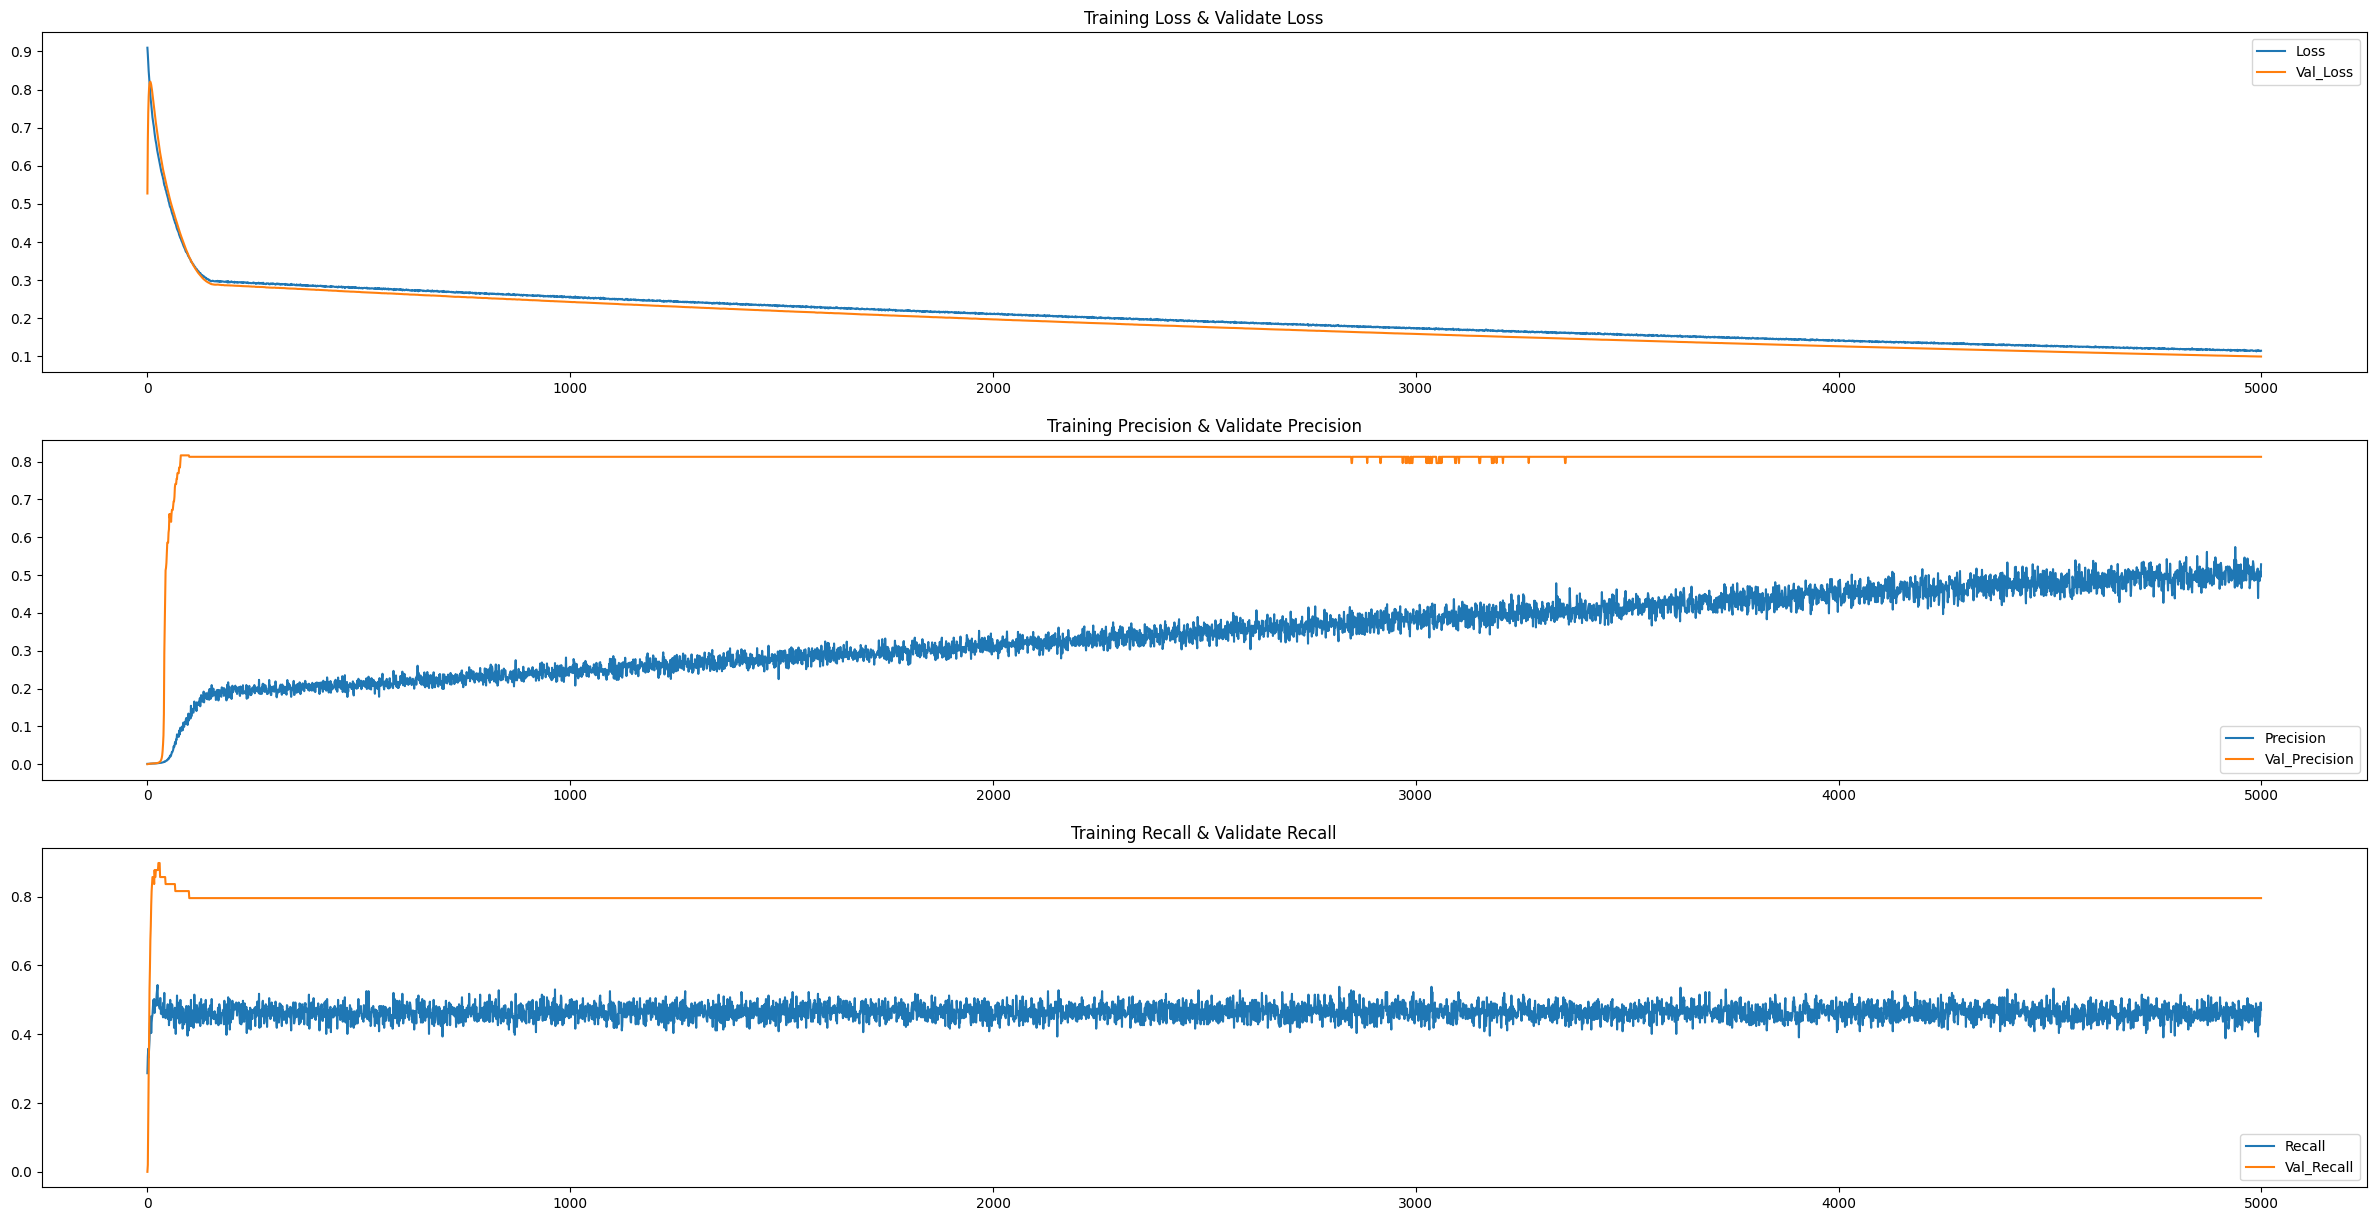

In [15]:
plt.figure(figsize = (30,15))

plt.subplot(3,1,1)
plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["val_loss"], label = "Val_Loss")
plt.title("Training Loss & Validate Loss")
plt.legend()

plt.subplot(3,1,2)
plt.plot(history.history["precision"], label = "Precision")
plt.plot(history.history["val_precision"], label = "Val_Precision")
plt.title("Training Precision & Validate Precision")
plt.legend()

plt.subplot(3,1,3)
plt.plot(history.history["recall"], label = "Recall")
plt.plot(history.history["val_recall"], label = "Val_Recall")
plt.title("Training Recall & Validate Recall")
plt.legend()


In [16]:
Ann_predict = tf.cast( model.predict(x_test) > 0.5, dtype = tf.float32)
print("Test Report = \n", classification_report(Ann_predict, y_test))

891/891 [==============================] - 1s 1ms/step
Test Report = 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     28435
         1.0       0.78      0.83      0.80        46

    accuracy                           1.00     28481
   macro avg       0.89      0.91      0.90     28481
weighted avg       1.00      1.00      1.00     28481



* 여러 시도를 해봤는데, 위의 방법으로는 epoch 수를 엄청 늘려야 점수가 좀더 올라갈 것으로 예상됨 (조금씩 precision / recall 이 오르는것 확인)
-> 시간상 epoch 을 많이 증가해서 돌리는것은 추후 확인

* recall 관련한 수치만 급격하게 오르고 precision 이 잘 오르지 않음
* 그래프가 이상함. weight initialize를 he_uniform -> he_normal로 바꿔 봤는데 그래프 끊김이 많았음. 다시 he_uniform으로 바꿔야 할것 같음
* relu를 activation function으로 쓰면 he 를 쓰는게 좋다는데 내가 만든 모델에서는 잘 모르겠음
* 여러가지를 막 추가한다고 좋게 나오는게 아닌것 같음.


## xgboost
마지막으로 xgboost 결과만 확인

overfitting 에 강하고 파라미터 조정으로 최적화된 모델을 만들 수 있음

In [18]:
from xgboost import XGBClassifier

Xgboost_model = XGBClassifier()
Xgboost_model.fit(x_train, y_train, eval_metric='aucpr') # eval_metric: f-score나 precision, recall에 민감할 때 사용

Xg_predict = tf.cast( Xgboost_model.predict(x_test) > 0.5, dtype = tf.float32)
print("Test Report = \n", classification_report(Xg_predict, y_test))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Test Report = 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     28437
         1.0       0.84      0.93      0.88        44

    accuracy                           1.00     28481
   macro avg       0.92      0.97      0.94     28481
weighted avg       1.00      1.00      1.00     28481

